# SCE Project Report - Surrogate Modelling of a Wing Weight Function </center>

![alt text](http---cdn.cnn.com-cnnnext-dam-assets-160727135306-iconic-aircraft-bleriot-xi-57341758.jpg "https://edition.cnn.com/travel/article/20-iconic-aircraft-vintage/index.html")

## Abstract

As computer simulations and numerical calculations are getting more complex, time and cost-intensive representative, emulating models are necessary. The surrogate modeling approach offers a solution to this demand. In this project, a surrogate model approach for a wing weight function is introduced. Using three different regression models and a subsequent evaluation, the target values of the wing weight function are predicted. <br>
Since the generated code is fitted into a python class, the relevant components and not the related class will be discussed in the following for the sake of the reader's understanding. 

## Table of Content
* [Surrogate Modelling](#first-bullet)
* [Libraries and Python Packages](#second-bullet)
* [The Wing Wieght Function](#third-bullet)
* [Generating the Dataset](#fourth-bullet)
    * [Latin Hypercube Sampling](#fourth.1-bullet)
    * [Extending the Dataset](#fourth.2-bullet)
* [Model Application](#fifth-bullet)
    * [Introduction to Regression](#fifth.1-bullet)
    * [Multiple Linear Regression](#fifth.2-bullet)
    * [Gaussian Process Regression](#fifth.3-bullet)
    * [Support Vector Regression](#fifth.4-bullet)
    * [Train Test Split](#fifth.5-bullet)
    * [Fitting the Regression Models](#fifth.6-bullet)
* [Model Performance Evaluation](#sixth-bullet)
    * [kFold Crossvalidation](#sixth.1-bullet)
    * [Evaluation](#sixth.2-bullet)
* [Summary](#seventh-bullet)

## Surrogate Modelling

Modeling and simulation are of particular importance for the design and operation of engineering problems and solutions. Efficiency increases can often be achieved by using models of higher complexity, whose solution is mathematically more complex and whose model structure is not always known. This makes the analysis and optimization of these models, particularly challenging. To address this problem, mathematically simplified surrogate models have been developed and successfully used in the recent past. [[1]](my-label)
A surrogate model approximates the black box prediction function $f$ of the conventional simulation as close as possible to the surrogate model prediction function $\hat{f}$, under the given constraints [[2]](my-label).

## Libraries and Python Packages

Starting by introducing the relevant packages and libraries for my program. Common libraries like _NumPy_, _Pandas_ and _Matplotlib_ were used for general data handling. Furthermore from the _Surrogate Modelling Toolbox_ (SMT)-library the _Latin Hypercube Sampling_ (LHS)-method was applied for the data set generation. The _SciKit-Learn_-library was introduced to gain access to the different implemented regression models. This library was also applied to perform the train and test split on the generated dataset for training and testing the implemented regression models.

In [ ]:
# Importing the standard data manipulation and visualisation packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics
import matplotlib.gridspec as gridspec

# Importing package for Latin Hypercube Sampling (LHS).
from smt.sampling_methods import LHS

# Importing package for train/test split.
from sklearn.model_selection import train_test_split

# Importing regression models
# Importing LinearRegression for the Multiple Linear Regression.
from sklearn.linear_model import LinearRegression 

# Importing GaussionProcessRegressor and the kernels (RBF, WhiteKernel) for the eponymous regression.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Importing SVM and SVR for the Support Vector Regression.
from sklearn import svm
from sklearn.svm import SVR

# Importing packages for kFold crossvalidation.
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

## The Wing Wieght Function

As the objective of the project is the surrogate modeling of the wing weight function, this function is introduced in the following. The function, provided by Surjaovic and Bingham is modeling a light aircraft wing and consists of 10 different variables each with a certain input range [[3]](my-label)

> $f(x)$ = $0.036  S_{w}^{0.758}  W_{fw}^{0.0035}  (\frac{A}{cos^{2}(\Lambda)})^{0.6}  q^{0.006}  \lambda^{0.04}  (\frac{100  t_{c}}{cos(\Lambda)})^{-0.3}  (N_{z}W_{dg})^{0.49} + S_{w}  W_{p}$ [[3]](my-label) <br>

|Variable |Input range|Definition|
|:-----|:----|:----|
|$S_{w}$ |[150, 200] |wing area ($ft^{2}$)|
|$W_{fw}$ |[220, 300] |weight of fuel in the wing ($lb$)|
|$A$ |[6, 10] |aspect ratio|
|$\Lambda$ |[-10, 10] |quarter-chord sweep ($degrees$)|
|$q$ |[16, 45] |dynamic pressure at cruise ($lb/ft^{2}$)|
|$\lambda$ |[0.5, 1] |taber ratio|
|$t_{c}$ |[0.08, 0.18] |aerofoil thickness to chord ratio|
|$N_{z}$ |[2.5, 6] |ultimate load factor|
|$W_{dg}$ |[1700, 2500] |flight design gross weight ($lb$)|
|$W_{p}$ |[0.025, 0.08] |paint weight ($lb/ft^{2}$)|

## Generating the Dataset

### Latin Hypercube Sampling

The introduction of the relevant libraries is followed by the generation of the data set. The LHS method is a statistical method to generate quasi-random samples by dividing the given dimension space into n (n: number of sampling points) in different sections and picking a sample in each according section [[4]](my-label). For the options, I chose the intervals of the variables in the given wing weight functions for the xlimits. Which describes the interval of the range in each dimension. The criterion, describing the LHS design was set to the default (center) option. The last option, the random_state was set to one, as the same dataset is necessary for the different regressions.[[4]](my-label) The result is a **data_wingweight** dataset with 1000 rows and 10 columns for each variable. However, the dataset size (1000) is variable in my created surrogate modeling class and can be adjusted individually.

In [6]:
# Dictionary with all parameters an their value ranges.
input_domain = {'S_w' : [150, 200],
                'W_fw' : [220, 300],
                'A' : [6, 10],
                'LamCaps' : [-10, 10],
                'q' : [16, 45],
                'lam' : [0.5, 1],
                't_c' : [0.08, 0.18],
                'N_z' : [2.5, 6],
                'W_dg' : [1700, 2500],
                'W_p' : [0.025, 0.08]
               }

# Executing the LHS method to generate the dataset
xlimits = np.array([input_domain['S_w'],
                    input_domain['W_fw'],
                    input_domain['A'],
                    input_domain['LamCaps'],
                    input_domain['q'],
                    input_domain['lam'],
                    input_domain['t_c'],
                    input_domain['N_z'],
                    input_domain['W_dg'],
                    input_domain['W_p'],]
                  )

sampling = LHS(xlimits=xlimits, random_state=1)

x = sampling(1000)

data_wingweight = pd.DataFrame(x, columns=['S_w',
                                           'W_fw',
                                           'A',
                                           'LamCaps',
                                           'q',
                                           'lam',
                                           't_c',
                                           'N_z',
                                           'W_dg',
                                           'W_p']
                              )

### Extending the Dataset

By using each row of the **data_wingweight** dataset as input for the wing weight function to calculate the corresponding output value for each variable configuration, the dataset is extended with an 11th column (**y_wingweight**). Implementing the function, that returns the output of the wing weight function as **y_wingweight**.

In [7]:
def wing_weight(data_wingweight):
    
    fact1 = 0.036 * data_wingweight['S_w']**0.758 * data_wingweight['W_fw']**0.0035
    fact2 = (data_wingweight['A'] / ((math.cos(data_wingweight['LamCaps'] * (math.pi/180)))**2))**0.6
    fact3 = data_wingweight['q']**0.006 * data_wingweight['lam']**0.04
    fact4 = (100*data_wingweight['t_c'] / math.cos(data_wingweight['LamCaps'] * (math.pi/180)))**(-0.3)
    fact5 = (data_wingweight['N_z'] * data_wingweight['W_dg'])**0.49
    
    term1 = data_wingweight['S_w'] * data_wingweight['W_p']
    
    y_wingweight = fact1 * fact2 * fact3 * fact4 * fact5 + term1
    
    return y_wingweight

# Adding the y_wingweight values as a new column to the data_wingweight dataframe.
data_wingweight['y_wingweight'] = data_wingweight.apply(wing_weight, axis=1)

As a result, the data frame now consists of 1000 rows and 11 columns which equals a total of 11000 data points. The table below represents the first five rows of the complete dataset.

In [8]:
data_wingweight.head()

,S_w,W_fw,A,LamCaps,q,lam,t_c,N_z,W_dg,W_p,y_wingweight
0,155.575,239.72,9.878,8.95,18.1605,0.65425,0.11375,5.01825,2221.2,0.049998,319.817537
1,178.125,245.72,9.674,-3.93,34.2555,0.76675,0.12985,3.75475,1915.6,0.075573,278.578827
2,162.775,226.52,6.226,5.65,32.3995,0.71425,0.10085,5.25625,2065.2,0.065068,261.164770
3,188.825,233.00,9.190,8.81,30.5725,0.87175,0.11735,5.72875,1864.4,0.037843,347.683824
4,159.925,235.24,8.030,-2.17,20.6835,0.87125,0.13115,3.46775,2002.0,0.068147,225.084396


## Model Application

### Introduction to Regression

In the area of data science and machine learning algorithms, a regression estimates the relationship between one or more variables. By using a variety of input variables a numerical value is being estimated. [[5]](my-label) In this project three different regression techniques were applied. The simplest _Multiple Linear Regression_ and the more complex _Gaussian Process_ and _Support Vector Regression_.

### Multiple Linear Regression

Multiple Linear Regression (MLR) is a rather simple regression approach. It extends the Linear Regression model by adding n more input variables to the regression function. The result is an output variable estimation based on, in the wing weight case, ten different input variables.

> $y = \beta_{0} + \beta_{1} X_{1} + ... + \beta_{n} X_{n} + \epsilon$ [[5]](my-label) <br>
> $\;\;\;$ $y$: the predicted value of the dependet variables <br>
> $\;\;\;$ $n$: the number of indipendent input variables <br>
> $\;\;\;$ $\beta_{0}$: the y-intercept (value of $y$ when all other parameters are set to 0) <br>
> $\;\;\;$ $\beta_{1} X_{1}$: the regression coefficient ($\beta_{1}$) of the first independent variable ($X_{1}$) <br>
> $\;\;\;$ $\beta_{n} X_{n}$: the regression coefficient of the last independent variable <br>
> $\;\;\;$ $\epsilon$: model error (how much variation there is in our estimate of $y$) <br>

### Gaussian Process Regression

The Gaussian Process Regression (GPR) is a supervised learning framework, utilizing the Bayesian approach to regression and classification problems [[7]](my-label). By using prior knowledge (kernels) the GPR model can make predictions and calculate uncertainties in these predictions [[8]](my-label). The Bayesian model defines a prior and posterior distribution on single parameter space. Moreover, a Bayesian non-parametric model, as used in the GPR, creates the Bayesian model on an infinite-dimensional parameter space [[9]](my-label).

> $p(x)$ ~ $GP(m(x), k(x, x^{'}))$  [[7]](my-label) <br>
> $\;\;\;$ $p(x)$: the probailistic model <br>
> $\;\;\;$ $m(x)$: the mean vecotor <br>
> $\;\;\;$ $k(x, x^{'})$: the covariance function <br>

### Support Vector Regression

The Support Vector Regression (SVR) is a supervised learning method introduced by the Support Vector Machines (SVM) used for regression problems [[10]](my-label). The SVM seperates a simple or multidimensional space into different classes by introducing lines or hyperplanes (multidimensional space). SVR adopts the same approach but for regression problems by acknnowlediging the non-linearity in the data and providing a proficient prediction model. [[11]](my-label) In the ende the SVR is similar to the GPR, as it is also a non-parametric technique that relies on kernel functions [[12]](my-label).

The model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.

### Train Test Split

Before performing the fitting and prediction of the regression model the given dataset needs to be split into a training and testing dataset. This is a common practice when performing supervised learning tasks. The _train_test_split_ function, introduced by _scikit-learn_, computes a random train and test split of the **data_wingweight** dataset [[13]](my-label). Before splitting the data, the input and output variables of the given data frame are assigned to the _X_ and _y_ variables. As shown in the code below, 70% of the data is used for training purposes and 30% for testing the trained model.

In [11]:
# Assigning the input variables to X and the output variables to y.
X = data_wingweight.iloc[:, 0:10]
y = data_wingweight.iloc[:, 10]

# Splitting the data_wingweight dataset into train and test sets with a 70/30 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

### Fitting the Regression Models

The predefined regression models from the _sklearn-library_ (introduced in chapter 1) are applied to the data. In addition, the _rbf-_ and the _sigmoid-kernels_ are added to the GPR and SVR models.

In [14]:
# The LinearRegressin() model is used for the MLR.
mlr = LinearRegression()

# The GaussianProcessRegressor() with a noise_std of 0.05 and the rbf-kernel is used for the GPR:
noise_std = 0.05
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-12, 1e10))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9)

# The SVR() with the sigmoid-kernel is used for the SVR.
svr_sigmoid = SVR(kernel='sigmoid', C=1e3, degree=2)

By using the _.fit(X_train, y_train)_ method, the MLR, GPR, and SVR models are fitted with the previously defined training data (**X_train** and **y_train**).

In [15]:
# Fitting the MLR model.
mlr.fit(X_train, y_train)

# Fitting the GPR model.
gpr.fit(X_train, y_train)

# Fitting the SVR model.
svr_sigmoid.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


SVR(C=1000.0, degree=2, kernel='sigmoid')

After the models have been trained and adjusted with the training data (**X_train**, **y_train**). In the next step, the models are applied to the test data (**X_test**, **y_test**) to evaluate the prediction of the output **y_pred_...**. In addition, the model is applied to the entire dataset **X**.

In [16]:
# Prediction of the test data.
y_pred_mlr = mlr.predict(X_test)

y_pred_gpr = gpr.predict(X_test)

y_pred_svr = svr_sigmoid.predict(X_test)


# Prediction of the full dataset.
y_pred_full_mlr = mlr.predict(X)

y_pred_full_gpr, std_prediction = gpr.predict(X, return_std=True)

y_pred_full_svr = svr_sigmoid.predict(X)

In the following graphs, the predicted (**y_pred_...**) and the observed (**y_wingweight**) values of the wing weight function are shown. The vertical line represents the exact correspondence between the two values.

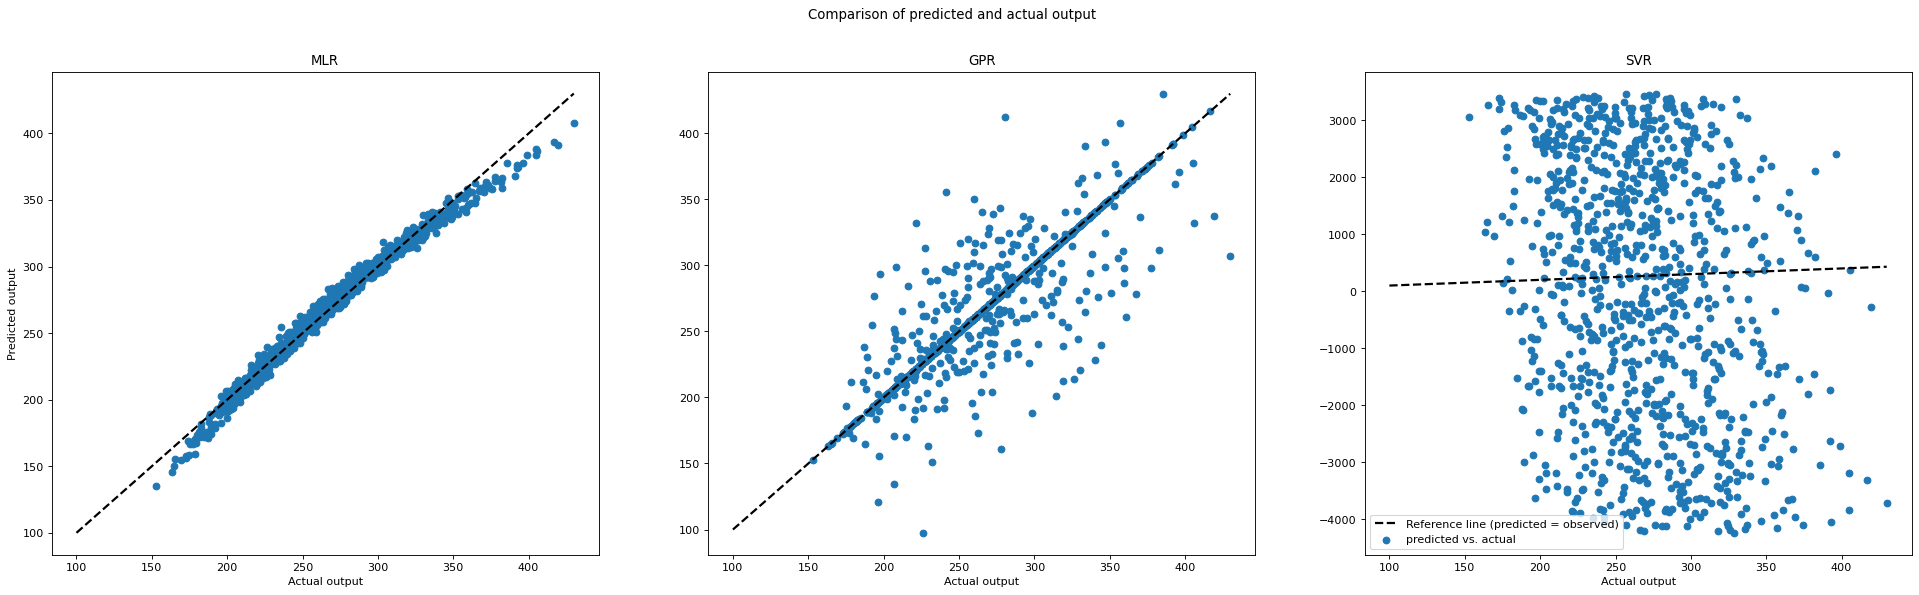

In [21]:
gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(30, 8), dpi=80)
#fig = plt.figure(constrained_layout=True)

ax = plt.subplot(gs[0, 0])
plt.scatter(y, y_pred_full_mlr)
plt.plot( [100, data_wingweight['y_wingweight'].max()], [100, data_wingweight['y_wingweight'].max()], linestyle='--', color='k', linewidth = 2, label='Reference line (predicted = observed)')
plt.xlabel('Actual output')
plt.ylabel('Predicted output')
plt.title('MLR')

ax = plt.subplot(gs[0, 1])
plt.scatter(y, y_pred_full_gpr)
plt.plot( [100, data_wingweight['y_wingweight'].max()], [100, data_wingweight['y_wingweight'].max()], linestyle='--', color='k', linewidth = 2, label='Reference line (predicted = observed)')
plt.xlabel('Actual output')
plt.title('GPR')

ax = plt.subplot(gs[0, 2])
plt.scatter(y, y_pred_full_svr, label='predicted vs. actual')
plt.plot( [100, data_wingweight['y_wingweight'].max()], [100, data_wingweight['y_wingweight'].max()], linestyle='--', color='k', linewidth = 2, label='Reference line (predicted = observed)')
plt.xlabel('Actual output')
plt.title('SVR')

plt.suptitle('Comparison of predicted and actual output')
plt.legend()

As shown in the graphs above, the MLR (left graph) is performing the best, as the points consisting of the predicted and observed values are very close or on the reference line. The GPR (middle graph) also shows a good result, although the points are more scattered around the reference line. The graph on the right shows the points from the SVR. These are the most coarsely distributed, indicating a greater deviation between the predicted and observed values.

## Model Performance Evaluation

### kFold Crossvalidation

Cross-validation helps in the evaluation of machine learning models. This statistical method is comparing the models in applied machine learning and supports the selection of the best performing one. _k-fold crossvalidation_ improves the model by validating the data. This technique ensures that the score of the model does not depend on the technique we use to select the test or training dataset. The _k-fold cross-validation_ method divides the data set into subsets with number **k**. Therefore, the verification method is repeated **k** times. [[14]](my-label)

### Evaluation

For the regression model evaluation, the _k-fold crossvalidation_ introduced in the previous section was applied to each regression model (MLR, GPR, SVR). The test dataset (**X_test**, **y_test**) was divided into **k = 10** subsets. For the comparison, three different assessment variables were applied. The _R-Squard_ (R2), the _Mean Squared Error_ (MSE) and the _Root Mean Squared Error_ (RMSE). The R2 value is the coefficient of determination, it provides information on how many points fall on the regression line. The MSE is calculated by taking the average of the square of the difference between the original and predicted values of the data. The lower the value, the better the model’s performance. The RMSE is the standard deviation of the errors which occur when a prediction is made on a dataset. This is the same as Mean Squared Error, but the root of the value is considered while determining the accuracy of the model. The lower the value, the better the predictive performance of the model. <br>
The code below shows an example of the R2 calculation. However, the calculation for the other two values is identical.

In [2]:
models = []

models.append(('MLR', mlr))
models.append(('GPR', gpr)) 
models.append(('SVR', svr_sigmoid))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X_test, y_test, scoring='r2', cv=cv, n_jobs=-1)
    results.append(absolute(n_scores))
    names.append(name)
    msg = "%s: %f (%f)" % (name, mean(absolute(n_scores)), std(absolute(n_scores)))
    print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 8), dpi=80)
plt.rcParams['font.size'] = '20'
fig.suptitle('Algorithm Comparison - R2')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('R2 score')
plt.show()

NameError: name 'mlr' is not defined

![kFold](kFold.png)

The right graph shows that the MLR has the most points on the regression line with an R2 value of **0.836760**. Furthermore, the MLR also shows the best performance in the middle graph, with an MSE value of **75.336643**. Finally, the RMSE value of the MLR is also the lowest at **7.792695**. In summary, MLR generally has the best model performance and predicts the wing weight values most accurately. 

## Summary

In this semester's project for the RWTH University course _Sustainable Computational Engineering_ I have built a surrogate model for a wing weight function with three different regressions (Multiple Linear Regression, Gaussian Process Regression, and Support Vector Regression).<br>
<br>
After generating a data set using the Latin Hypercube Sampling method, I split the data set into training and test data to train and validate the regression models. After I applied the models to the entire data set, the performance of the models was evaluated. For this purpose, k-fold cross-validation was introduced and the regressions were compared using different error scores. Finally, the best performing model was highlighted and thus a successful surrogate model for the given wing weight function was introduced.

## References

[[1]](my-label) Molnar, [www.christophm.github.io](https://christophm.github.io/interpretable-ml-book/global.html), [08.08.2022, 10:31 pm] <br>
[[2]](my-label) Molnar, Introducing Surrogate Models to the Structural Preliminary Aircraft Desfign Phase, Deutscher Luft- und Raumfahrtkongress, 2018 <br>
[[3]](my-label) Surjaovic and Bingham, [www.sfu.ca](https://www.sfu.ca/~ssurjano/wingweight.html), [31.07.2022, 04:02 pm] <br>
[[4]](my-label) Hwang, [www.smt.readthedocs.io](https://smt.readthedocs.io/en/latest/_src_docs/sampling_methods/lhs.html), [31.07.2022, 03:52 pm] <br>
[[5]](my-label) DataRobot, [www.datarobot.com](https://www.datarobot.com/wiki/regression/), [31.07.2022, 05:57 pm] <br>
[[6]](my-label) Bevans, [www.scribbr.com](https://www.scribbr.com/statistics/multiple-linear-regression/), [31.07.2022, 06:43 pm] <br>
[[7]](my-label) Fonnesbeck, [www.dominodatalab.com](https://www.dominodatalab.com/blog/fitting-gaussian-process-models-python), [06.08.2022, 10:50 am] <br>
[[8]](my-label) Wanga, An Intuitive Tutorial to Gaussian Processes Regression, Elsevier, 2020 <br>
[[9]](my-label) Orbanz and Teh, Bayesian Nonparametric Models, Cambridge University, 2010 <br>
[[10]](my-label) scikit-learn developers, [www.scikit-learn.org](https://scikit-learn.org/stable/modules/svm.html#svm-regression), [06.08.2022, 11:48 am] <br>
[[11]](my-label) Sethi, [www.analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/), [06.08.2022, 11:49 am] <br>
[[12]](my-label) Sethi, [www.mathworks.com](https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html), [06.08.2022, 11:50 am] <br>
[[13]](my-label) scikit-learn developers, [www.scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), [06.08.2022, 12:16 pm] <br>
[[14]](my-label) Data Science Team, [www.datascience.eu](https://datascience.eu/de/maschinelles-lernen/k-fache-kreuzvalidierung/), [06.08.2022, 16:56 pm] <br>